# Debugging `percolate`

## 1. Dealing with the random empty clusters

Some structures percolate at a given temperature $T_1$ but not at another temperature $T_2 > T_1$. This is clearly an erroneous result because if a spanning cluster forms at $T_1$, it must also be realisable at $T_2 > T_1$.

In [17]:
%matplotlib widget

from os import path
import pickle
import numpy as np
from numba import njit
from qcnico.plt_utils import histogram


def get_dcrits(run_inds,temps,datadir):
    nsamples = len(run_inds)
    ntemps = len(temps)
    dcrits = np.zeros((nsamples,ntemps))
    for k in range(nsamples):
        for l in range(ntemps):
            sampdir = f"sample-{run_inds[k]}"
            pkl = f"out_percolate-{temps[l]}K.pkl"
            fo = open(path.join(datadir,sampdir,pkl),'rb')
            dat = pickle.load(fo)
            dcrits[k,l] = dat[1]
            fo.close()

    return dcrits

datadir=path.expanduser("~/Desktop/simulation_outputs/percolation/40x40/percolate_output")
fgood_runs = path.join(datadir, 'good_runs.txt')
with open(fgood_runs) as fo:
    lines = fo.readlines()

# 'Good run' indices
gr_inds = np.array(list(map(int,[line.rstrip().lstrip() for line in lines])))

# temps = np.arange(0,1050,50)
# temps[0] = 10
temps = np.arange(40,440,10)

dcrits = get_dcrits(gr_inds,temps, datadir)
print(dcrits.shape)

davg_T = np.mean(dcrits,axis=0)
dstd_T = np.std(dcrits,axis=0)
print(davg_T.shape)


(174, 40)
(40,)


Check which structures have increasing critical distances with increasing $T$.

In [2]:
ddiffs = np.diff(dcrits)
print("All critical distances decrease with temperature: ", np.all(ddiffs<=0))

All critical distances decrease with temperature:  True


Ok, so for all structures at all $T$: 
$$\frac{\partial d_c}{\partial T} \le 0\,.$$
Good.

Now let's examine the instances where no percolating cluster is found.

In [29]:
def get_clusters_sizes(run_inds,temps,datadir):
    nsamples = len(run_inds)
    ntemps = len(temps)
    sizes = np.zeros((nsamples,ntemps),dtype=int)
    for k in range(nsamples):
        for l in range(ntemps):
            sampdir = "sample-" + str(run_inds[k]) #fstrings don't work in Numba
            pkl = "out_percolate-" + str(temps[l]) + "K.pkl"
            with open(path.join(datadir,sampdir,pkl),'rb') as fo:
                dat = pickle.load(fo)
                c = dat[0]
            if len(c) > 0:
                sizes[k,l] = len(c[0]) #there is only one cluster each time
            else:
                sizes[k,l] = 0
    return sizes

csizes = get_clusters_sizes(gr_inds,temps,datadir)
zero_cluster_inds = (csizes == 0).nonzero()
print("Sample nb. and temperatures where no percolation occured:")
print(np.vstack((gr_inds[zero_cluster_inds[0]], temps[zero_cluster_inds[1]])).T)

Sample nb. and temperatures where no percolation occured:
[[ 25 150]
 [104  80]
 [123  40]
 [161 130]
 [188  80]
 [239  70]]


Let's check out sample 25 and what happens around $T =150\,\text{K}$.

In [31]:
from qcnico.coords_io import read_xsf

def get_cluster_data(run_ind,nMOs,temps,datadir):
    ntemps = len(temps)
    clusters = []
    adjmats = np.zeros((ntemps,nMOs,nMOs),dtype=bool)
    for l in range(ntemps):
        sampdir = "sample-" + str(run_ind) #fstrings don't work in Numba
        pkl = "out_percolate-" + str(temps[l]) + "K.pkl"
        with open(path.join(datadir,sampdir,pkl),'rb') as fo:
            dat = pickle.load(fo)
            clusters.append(dat[0])
            adjmats[l,:,:] = dat[2]
    return clusters, adjmats


gr_nn = zero_cluster_inds[0][0]
nn = gr_inds[gr_nn] # should equal 25
print(nn)
Tsample_inds = np.array([0,10,11,12,-1])
Tsample = temps[Tsample_inds]

posdir = path.join(path.dirname(datadir), 'structures')
Mdir = path.join(path.dirname(datadir), 'MOs_ARPACK')
edir = path.join(path.dirname(datadir), 'eARPACK')

posfile = path.join(posdir,f'bigMAC-{nn}_relaxed.xsf')
Mfile = path.join(Mdir,f'MOs_ARPACK_bigMAC-{nn}.npy')
efile = path.join(edir, f'eARPACK_bigMAC-{nn}.npy')
locfile = path.join(datadir,f'sample-{nn}','cc.npy')
eefile = path.join(datadir,f'sample-{nn}','ee.npy')

pos, _ = read_xsf(posfile)
M = np.load(Mfile)
energies = np.load(efile) #energies appear only once (apart from degeneracies)
loc_centers = np.load(locfile)
ee = np.load(eefile) #each energy appears as many times as its associated has localisation centres

clusters, adjmats = get_cluster_data(25,loc_centers.shape[0],temps,datadir)

25


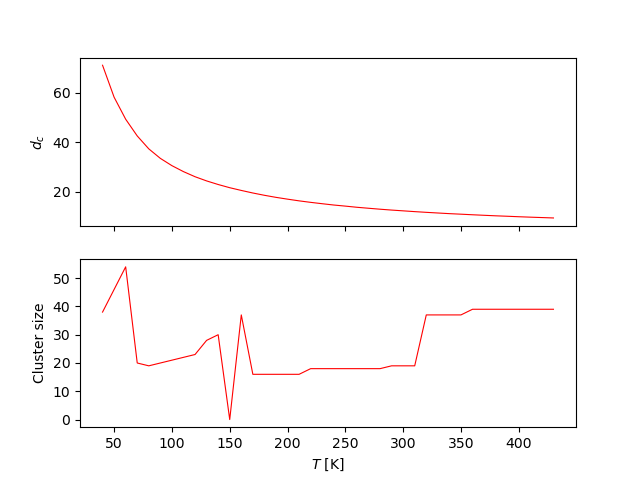

In [30]:
import matplotlib.pyplot as plt

dd25 = dcrits[gr_nn,:]
cs25 = csizes[gr_nn,:]

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(temps,dd25,'r-',lw=0.8)
axs[1].plot(temps,cs25,'r-',lw=0.8)
axs[0].set_ylabel('$d_c$')          
axs[1].set_xlabel('$T$ [K]')
axs[1].set_ylabel('Cluster size')
plt.show()

In [34]:
from percolate import diff_arrs

kB = 8.617e-5
T = 150 #K

edarr, rdarr = diff_arrs(ee,loc_centers,a0=30,eF=0)
MA_dists = (edarr/(kB*T)) +  rdarr
print(np.max(MA_dists))
print(dd25[11])


55.32550988391601
21.718544766178606


Figured out the issue; turns out the `percolate` function returned an empty cluster upon reaching the $N^{\text{th}}$ distance, as oppose to the ${N(N-1)/2}^{\text{th}}$ (in increasing order). In other words, it thought it was finished looking at all the inter-centre distances in the structure, when in fact, it still had a bunch more distances to check. 
Issue is fixed now.

Now onto the next issue.

## Clusters with only two overlapping centers

Some clusters are comprised of only two localisation centres whose spatial position overlap. This does not seem correct, as the likelihood of having two MOs coupled to opposite edges coarse-grained to the same localisation centre is quite small. It is possible though, if we have an MO with split localisation on both edges. Let's investigate.

In [ ]:
tiny_cluster_inds = (csizes == 2).nonzero()


